This Notebook is mainly an exploratory analysis of the HearthPWN Dataset. The main focus is to perform visual and predictive analysis.

- The main idea of this project is to explore the Hearthpwn hearthstone decks dataset
- The two datasets used are the data of all decks created on Hearthpwn and the data of all existing cards
- The main packages used are pandas(data structure), matplotlib(graphing tool) and sklearn(machine learning tool)

Since Hearthstone is constantly coming out with new cards whilst balancing the rest, I am interested in how this would contribute to the meta of the game. 

In [1]:
## All the Libraries used

import os
import numpy as np
import json
import pandas as pd
from collections import Counter
import csv
import matplotlib.pyplot as plt
from sklearn import neighbors, metrics, grid_search, cross_validation
##import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier



pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline

plt.style.use('ggplot')


In [2]:
## reading heartpwn dataset

data_df = pd.read_csv(os.path.join('data.csv'))

data_df['date'] = pd.to_datetime(data_df['date'])
data_df

,craft_cost,date,deck_archetype,deck_class,deck_format,...,card_25,card_26,card_27,card_28,card_29
0,9740,2016-02-19,Unknown,Priest,W,...,2582,2683,2736,2568,2883
1,9840,2016-02-19,Unknown,Warrior,W,...,2064,2078,2510,2729,2736
2,2600,2016-02-19,Unknown,Mage,W,...,2064,2064,2078,38710,38710
3,15600,2016-02-19,Unknown,Warrior,W,...,336,2729,2729,2736,2760
4,7700,2016-02-19,Unknown,Paladin,W,...,374,2717,2717,2889,2889
...,...,...,...,...,...,...,...,...,...,...,...
346227,5480,2016-04-25,Unknown,Paladin,S,...,38745,38781,38781,38911,38911
346228,3840,2016-02-07,Unknown,Rogue,S,...,1158,1372,1651,2884,2884
346229,5580,2016-02-07,Unknown,Paladin,W,...,2883,2889,2901,2949,2951
346230,5160,2016-02-07,Unknown,Druid,S,...,2782,2782,2948,38319,38319


In [3]:
## reading card dataset

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

# Primary Analysis

In [198]:
## Average cost for crafting decks

print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'S'))
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'W'))

6020.33807806
5280.29069105


On average, Standard decks cost more dust than Wild decks.

In [199]:
Counter(data_df.deck_format)

Counter({'S': 170786, 'W': 175444})

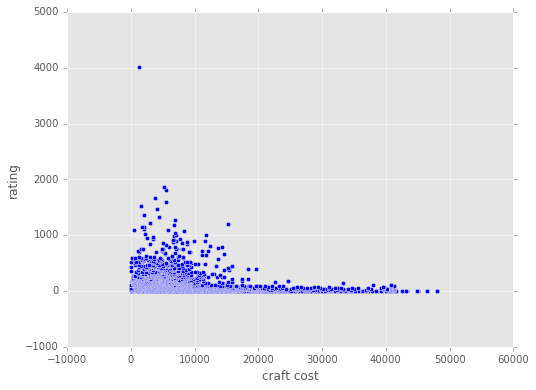

In [203]:
## Graph: craft cost vs deck rating

plt.figure(figsize=(8,6))
plt.scatter(data_df.craft_cost, np.sort(data_df.rating.values))
plt.xlabel('craft cost', fontsize=12)
plt.ylabel('rating', fontsize=12)
plt.show()

Most of the decks cost less than 10000 to craft, but there are also "troll" decks that costs as much as 45000 dust to craft

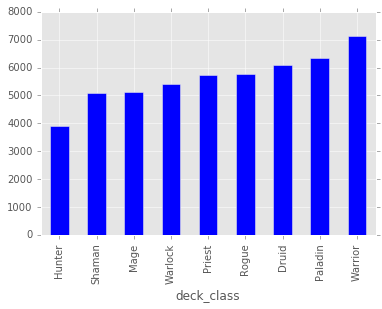

In [204]:
## Graph: craft cost vs deck class

c = data_df.craft_cost.groupby(data_df.deck_class).mean()
c.sort_values(inplace=True)
c.plot(kind = 'bar')

From the graph, Warrior decks often cost the most to craft, whilst Hunter decks are the cheapest

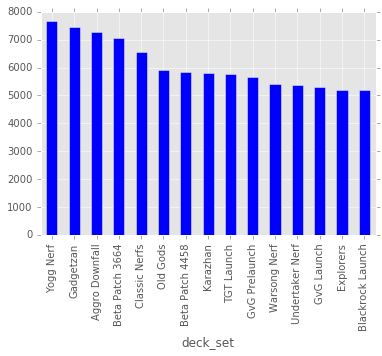

In [205]:
## Graph: craft cost vs expansion

c = data_df.craft_cost.groupby(data_df.deck_set).mean()
c.sort_values(inplace=True, ascending = False)
c[:15].plot(kind = 'bar')

# Further Analysis


## Releases and meta

### Clean and Setup

In [5]:
## reloading and cleaning data sets 
## Dropping Travern Brawl decks since its decks and rules does not apply to the rest of the game

data_df = pd.read_csv(os.path.join('data.csv'))

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

data_df['date'] = pd.to_datetime(data_df['date'])
refs.race.fillna('Normal', inplace=True)
data_df = data_df.drop(data_df.deck_type == 'Tavern Brawl')
refs.cost.fillna(0,inplace=True)

card_col = ['card_{}'.format(str(i)) for i in range(30)]

In [6]:
## merging data with card dictionary

result = data_df.copy()
result = result.reset_index(drop = True)

for x in range(30):
    result = pd.merge(result, refs, left_on = result[card_col[x]], right_on = refs.dbfId, how = 'left')

### Race

In [7]:
## creating Race columns and its sum

races = refs.race.unique()
race_df = pd.DataFrame(index=result.index)
for x in range(len(races)):
    race_df[races[x]] = 0
    
dum = [result['race_x'],result['race_y']]
    
for x in range(len(result)):
    out = Counter(dum[0].ix[x]) + Counter(dum[1].ix[x])
    for i in range(len(races)):
        race_df = race_df.set_value(x, races[i], out[races[i]])

In [8]:
## Adding date and release to dataframe

race_df['date'] = result.date
race_df['deck_set'] = result.deck_set

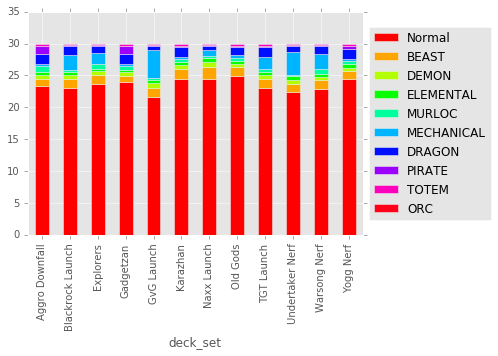

In [9]:
## Looking at Releases that contributed to the most deck creations and its race distribution

trial = race_df.copy()

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = trial['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
trial['deck_set'].replace(to_remove, np.nan, inplace=True)
trial = trial.dropna(how = 'any')

d = trial.groupby(trial.deck_set).mean()

d.drop(['Beta Patch 3937'],axis = 0, inplace = True)
d.drop(['Live Patch 5506'],axis = 0, inplace = True)

d.plot(kind = 'bar',stacked = True, colormap='hsv').legend(loc='center left', bbox_to_anchor=(1, 0.5))

- it's obvious that after GVG launch, the amount of Mechs ina deck increased because GVG pushed out a lot of mech cards.
- With the releasae of Gadgetzan, the average number of Dragon's increase due to popularization of Dragon Priest decks

### Card Cost

In [10]:
## dataframes used are from before

result_copy = result.copy()

In [11]:
## Creating cost columns and its sum

costs = refs.cost.unique()
cost_df = pd.DataFrame(index=result.index)
for x in range(len(costs)):
    cost_df[costs[x]] = 0
    
dum = [result_copy['cost_x'],result_copy['cost_y']]
    
for x in range(len(result_copy)):
    out = Counter(dum[0].ix[x]) + Counter(dum[1].ix[x])
    for i in range(len(costs)):
        cost_df = cost_df.set_value(x, costs[i], out[costs[i]])

In [12]:
## Adding date and release to dataframe

cost_df['date'] = result_copy.date
cost_df['deck_set'] = result_copy.deck_set

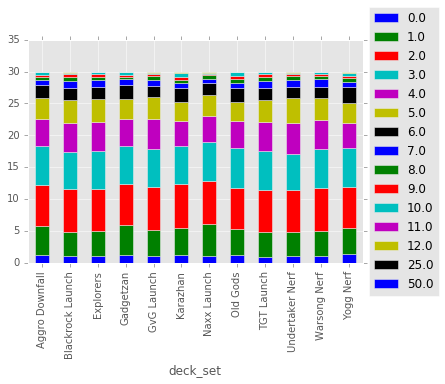

In [13]:
## Looking at Releases that contributed to the most deck creations and its race distribution

trial1 = cost_df.copy()

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = trial1['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
trial1['deck_set'].replace(to_remove, np.nan, inplace=True)
trial1 = trial1.dropna(how = 'any')
trial1 = trial1.reindex_axis(sorted(trial1.columns), axis=1)

b = trial1.groupby(trial1.deck_set).mean()

b.drop(['Beta Patch 3937'],axis = 0, inplace = True)
b.drop(['Live Patch 5506'],axis = 0, inplace = True)

b.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

- Naxx Launch introduced more low cost cards into decks
- Gadgetzan also introduce some low cost cards, which led to early game decks such as mech mage and mech shaman

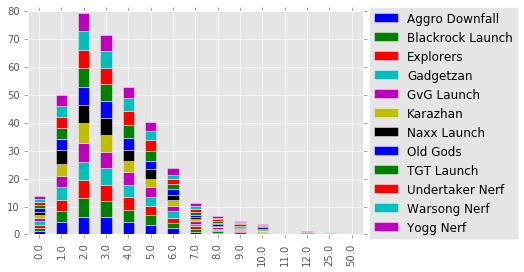

In [14]:
b = b.transpose()
b.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

This shows that across the releases, the average setup of the deck, card cost wise, all look similar.

###  Class

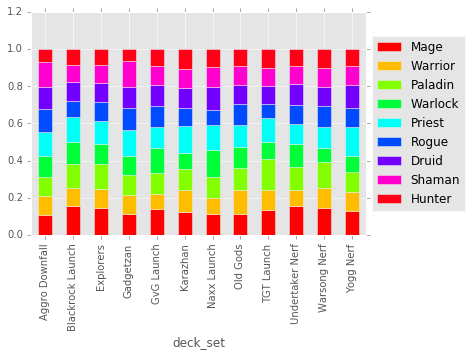

In [15]:
deck_df = result.copy()
deck_df = deck_df[['deck_class','deck_set']]

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = deck_df['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
deck_df['deck_set'].replace(to_remove, np.nan, inplace=True)
deck_df = deck_df.dropna(how = 'any')
deck_df = deck_df.reset_index(drop = True)

difclass = deck_df.deck_class.unique()
for x in range(len(difclass)):
    deck_df[difclass[x]] = 0
    
for x in range(len(deck_df)):
    deck_df = deck_df.set_value(x, deck_df.ix[x][0], 1)    

b = deck_df.groupby(deck_df.deck_set).mean()

b.drop(['Beta Patch 3937'],axis = 0, inplace = True)
b.drop(['Live Patch 5506'],axis = 0, inplace = True)

b.plot(kind = 'bar',stacked = True, colormap='hsv').legend(loc='center left', bbox_to_anchor=(1, 0.5))

- Naxx Launch led to an increase in Warlock decks because of cards like Voidcaller and Undertaker
- TGT Launch led to an increase in Paladin decks because of cards like Murloc knight and Mysterious Challenger

### Deck Archetype

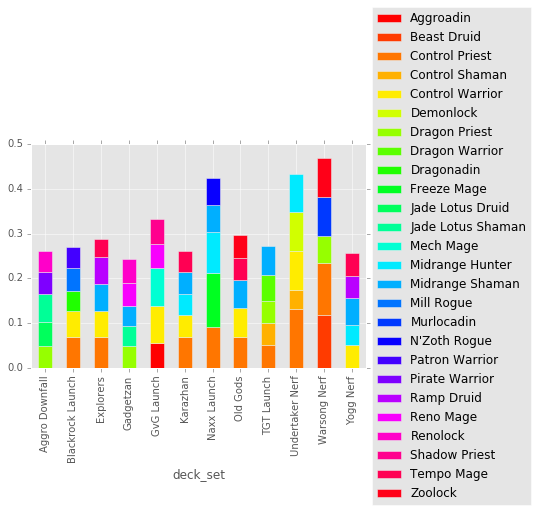

In [16]:
arch_df = result.copy()
arch_df = arch_df[['deck_archetype','deck_set']]

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = arch_df['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
arch_df['deck_set'].replace(to_remove, np.nan, inplace=True)
arch_df = arch_df.dropna(how = 'any')
arch_df = arch_df[arch_df.deck_archetype != 'Unknown']
arch_df = arch_df.reset_index(drop = True)


archetype = arch_df.deck_archetype.unique()
for x in range(len(archetype)):
    arch_df[archetype[x]] = 0
    
for x in range(len(arch_df)):
    arch_df = arch_df.set_value(x, arch_df.ix[x][0], 1)    

b = arch_df.groupby(arch_df.deck_set).mean()

b_copy = b.copy()
b_copy = b_copy.transpose()

c = b_copy.apply(lambda x: x.sort_values(ascending=False).head(5), axis=0)
c = c.transpose()


c.drop(['Beta Patch 3937'],axis = 0, inplace = True)
c.drop(['Live Patch 5506'],axis = 0, inplace = True)

c.dropna(axis = 1, how = 'all', inplace = True)


c.plot(kind = 'bar',stacked = True,colormap='hsv').legend(loc='center left', bbox_to_anchor=(1, 0.5))

- with Undertaker and Warsong Nerf, there is a rise in Control decks
- The GVG Launch also introduced Mech Mage
- Control Priest can be seen across most releases due to its power in all metas
- Aggro Downfall led to an increase in Jade decks due to its late game power

## Prediction: Archetype

 - This section is focused on using Classifier algorithms to predict Archetypes
 - Tavern brawl are excluded from data

### setup

In [17]:
data_copy = data_df.copy()

data_copy = data_copy.loc[:,'craft_cost':'rating']
data_copy = data_copy.drop('deck_id', axis = 1)
data_copy = data_copy.reset_index(drop = True)

In [18]:
race_copy = race_df.copy()
race_copy = race_copy.drop('date', axis = 1)
race_copy = race_copy.drop('deck_set', axis = 1)

data_copy = pd.concat([data_copy, race_copy], axis=1)

In [19]:
cost_copy = cost_df.copy()

cost_copy = cost_copy.drop('date', axis = 1)
cost_copy = cost_copy.drop('deck_set', axis = 1)

data_copy = pd.concat([data_copy, cost_copy], axis=1)

In [20]:
data_copy = data_copy[data_copy.deck_archetype != 'Unknown']
data_copy = data_copy.reset_index(drop = True)

In [21]:
test = pd.get_dummies(data_copy.deck_class, prefix='dum')
data_copy = pd.concat([data_copy, test], axis=1)

test = pd.get_dummies(data_copy.deck_format, prefix='dum')
data_copy = pd.concat([data_copy, test], axis=1)

test = pd.get_dummies(data_copy.deck_type, prefix='dum')
data_copy = pd.concat([data_copy, test], axis=1)

test = pd.get_dummies(data_copy.deck_set, prefix='dum')
data_copy = pd.concat([data_copy, test], axis=1)

data_copy = data_copy.drop('deck_class', axis = 1)
data_copy = data_copy.drop('deck_format', axis = 1)
data_copy = data_copy.drop('deck_type', axis = 1)
data_copy = data_copy.drop('deck_set', axis = 1)


### Random Forest Classification

In [22]:
msk = np.random.rand(len(data_copy)) <= 0.7

train = data_copy[msk]
test = data_copy[~msk]

y_train = train.deck_archetype
X_train = train.drop('deck_archetype', axis = 1)
X_train = X_train.drop('date', axis = 1)

y_test = test.deck_archetype
X_test = test.drop('deck_archetype', axis = 1)
X_test = X_test.drop('date', axis = 1)

In [23]:
model = RandomForestClassifier(n_estimators = 25, oob_score = True)
print model.fit(X_train,y_train).score(X_train,y_train)

print model.score(X_test, y_test)

0.993612207169
0.783300134935


- Random Forest Classifier with 25 estimators and with 70% of the dataset produces a model that fits 99.36%
- The test dataset (30%) produced a 78% score

In [24]:
check = pd.DataFrame(index = X_train.columns)
check['importance'] = model.feature_importances_

In [25]:
check.sort_values(by = 'importance', axis = 0, inplace = True, ascending = False)
check

,importance
craft_cost,0.081184
Normal,0.060624
1.0,0.054187
DRAGON,0.045208
6.0,0.045191
...,...
50.0,0.000000
dum_GvG Prelaunch,0.000000
ORC,0.000000
11.0,0.000000


- a closer look at the model showed that craft_cost of the deck and amount of Normal cards are heavy influencers to a deck's archetype
- variables such as ORC(race) and 50.0(card_cost) have such low influence is because cards with those attributes are rarely used in a deck

#### improving score

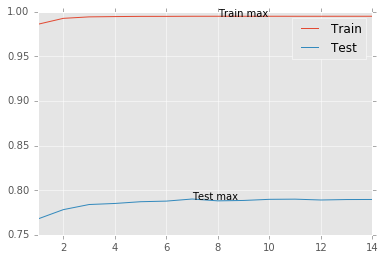

In [161]:
## changing the N-Estimators to see whether the model gains accuracy as N-Estimators increase

rf_trees = pd.DataFrame(index = range(1,15))
rf_trees['Train'] = 0.00
rf_trees['Test'] = 0.00

for x in range(1,15):
    y = x * 10
    model = RandomForestClassifier(n_estimators = y, oob_score = True)
    rf_trees['Train'][x] = model.fit(X_train,y_train).score(X_train,y_train)

    rf_trees['Test'][x] = model.score(X_test, y_test)

    
rf_trees.plot(use_index = True)
plt.annotate('Train max', xy=(rf_trees['Train'].idxmax(),rf_trees['Train'].max()))
plt.annotate('Test max', xy=(rf_trees['Test'].idxmax(),rf_trees['Test'].max()))

- The highest Train set accuracy reached was with 8 N-Estimators
- The highest Test set accuracy reached was with 7 N-Estimators

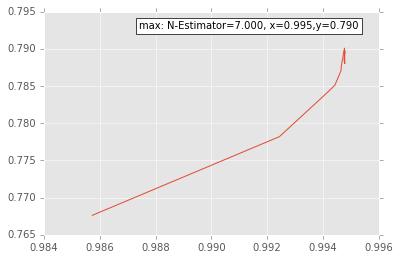

In [182]:
plt.plot(rf_trees['Train'],rf_trees['Test'])

def annot_max(x,y, ax=None):
    xmax = rf_trees['Train'][np.argmax(rf_trees['Test'])]
    ymax = rf_trees['Test'].max()
    text= "max: N-Estimator={:.3f}, x={:.3f},y={:.3f}".format(rf_trees['Test'].idxmax(),xmax,ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    plt.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(rf_trees['Train'],rf_trees['Test'])

- Similar to the graph above, this graph shows Test set accuracy is max at 70 N-Estimators
- We are more concerned with accuracy with Test set since the accuracy of Train set has plateaued
- Therefore I'll be using 70 N-Estimators, with Test score: 0.995 and Train score: 0.790

### Summary

- Across all Meta and releases, priest always shine.
- Mages are most affected by releases, ie increased decks
- Hutner decks never venture into control type decks, mainly low to mid.
- For every release, Blizzard made sure to release more low mana cost cards and less high mana cost cards
- Eventhough RandomForest Classifier produces 99.5% accuracy for testing set, training set only produce 79% accuracy
- Meaning, the model can correcly predict a deck's archetype ~80% of the time.